In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import openai
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set your OpenAI API key
openai.api_key = ''

In [3]:
# Step 1: Load the dataset
file_path = '3026NMfixed_UT.csv'
dataset = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(dataset.head())

   Speaker                       utterance  ut
0        2                      Nope. No.   10
1        2                       Yes. No.   10
2        2                          Yeah.   10
3        2                      Movement.    9
4        2  Distance traveling over time.    9


In [4]:
# Function to get GPT-3 embeddings for a given text
def get_gpt3_embeddings(text_list, batch_size=10):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        response = openai.Embedding.create(model="text-embedding-ada-002", input=batch)
        embeddings.extend([res['embedding'] for res in response['data']])
    return np.array(embeddings)

In [5]:
# Get GPT-3 embeddings for the 'utterance' column
X_text = get_gpt3_embeddings(dataset['utterance'].tolist())

In [6]:
# Step 3: Dimensionality Reduction (Optional but can help with noise)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_text)

In [10]:
# Step 4: Function to evaluate clustering configuration using silhouette score
def evaluate_clustering(n_clusters, data, method='kmeans'):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = model.fit_predict(data)
    elif method == 'dbscan':
        model = DBSCAN(eps=0.5, min_samples=5)
        labels = model.fit_predict(data)
    elif method == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(data)
    else:
        raise ValueError("Unknown method")
    
    # Ensure there are at least 2 clusters
    if len(set(labels)) > 1:
        score = silhouette_score(data, labels)
    else:
        score = -1  # Invalid score for configurations with less than 2 clusters
    return score

In [11]:
# Simulated Annealing function for clustering
def simulated_annealing(data, max_clusters=30, iterations=300, initial_temp=1000, cooling_rate=0.95, method='kmeans'):
    best_score = -1
    best_k = 2
    scores = []
    temperatures = []
    
    current_k = np.random.randint(2, max_clusters + 1)
    current_score = evaluate_clustering(current_k, data, method=method)
    temperature = initial_temp
    
    for i in range(iterations):
        next_k = np.random.randint(2, max_clusters + 1)
        next_score = evaluate_clustering(next_k, data, method=method)
        
        if next_score > current_score or np.random.rand() < np.exp((next_score - current_score) / temperature):
            current_k = next_k
            current_score = next_score
        
        if current_score > best_score:
            best_score = current_score
            best_k = current_k
        
        scores.append(current_score)
        temperatures.append(temperature)
        
        temperature *= cooling_rate

    return best_k, best_score, scores, temperatures

In [12]:
# Try different clustering methods
methods = ['kmeans', 'dbscan', 'agglomerative']
results = {}

for method in methods:
    optimal_k, optimal_score, scores, temperatures = simulated_annealing(X_reduced, max_clusters=30, iterations=300, initial_temp=1000, cooling_rate=0.95, method=method)
    results[method] = {
        'optimal_k': optimal_k,
        'optimal_score': optimal_score,
        'scores': scores,
        'temperatures': temperatures
    }
    print(f"Method: {method}")
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Best silhouette score: {optimal_score}")

Method: kmeans
Optimal number of clusters: 29
Best silhouette score: 0.14154773920287408
Method: dbscan
Optimal number of clusters: 2
Best silhouette score: -1
Method: agglomerative
Optimal number of clusters: 30
Best silhouette score: 0.1341637942279533


In [13]:
# Choose the best method based on the silhouette score
best_method = max(results, key=lambda method: results[method]['optimal_score'])

In [14]:
# Perform final clustering with the optimal number of clusters
if best_method == 'kmeans':
    model = KMeans(n_clusters=results[best_method]['optimal_k'], random_state=42, n_init=10)
elif best_method == 'dbscan':
    model = DBSCAN(eps=0.5, min_samples=5)
elif best_method == 'agglomerative':
    model = AgglomerativeClustering(n_clusters=results[best_method]['optimal_k'])
    
final_labels = model.fit_predict(X_reduced)

In [15]:
# Display the cluster labels for the first few utterances
dataset['Cluster'] = final_labels
print(dataset.head())

   Speaker                       utterance  ut  Cluster
0        2                      Nope. No.   10        5
1        2                       Yes. No.   10        5
2        2                          Yeah.   10        6
3        2                      Movement.    9        8
4        2  Distance traveling over time.    9        9


In [16]:
# Step 5: Visualize the clusters using t-SNE

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

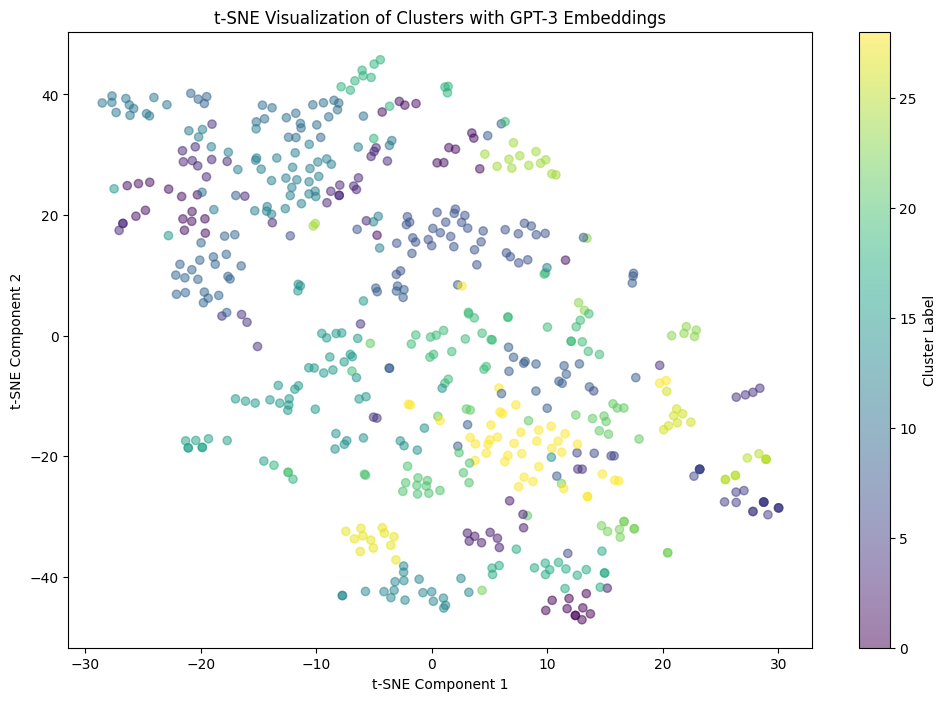

In [17]:
# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=final_labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Clusters with GPT-3 Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

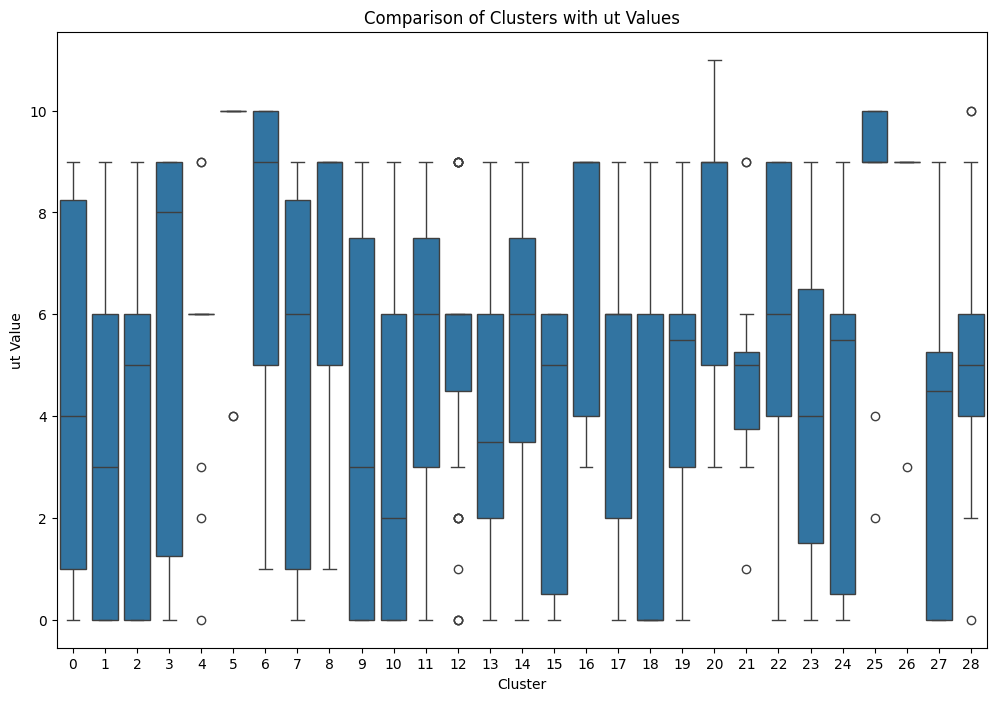

In [18]:
# Step 6: Compare Clusters with 'ut' Values

# Box plot to visualize the distribution of 'ut' values across clusters
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='ut', data=dataset)
plt.title('Comparison of Clusters with ut Values')
plt.xlabel('Cluster')
plt.ylabel('ut Value')
plt.show()

In [19]:
# Statistical summary of 'ut' values in each cluster
cluster_summary = dataset.groupby('Cluster')['ut'].describe()
print(cluster_summary)

         count      mean       std  min    25%   50%    75%   max
Cluster                                                          
0         10.0  4.500000  3.719319  0.0   1.00   4.0   8.25   9.0
1         27.0  3.185185  3.351659  0.0   0.00   3.0   6.00   9.0
2         11.0  3.818182  3.250175  0.0   0.00   5.0   6.00   9.0
3         26.0  5.423077  3.961546  0.0   1.25   8.0   9.00   9.0
4         15.0  5.533333  2.325838  0.0   6.00   6.0   6.00   9.0
5         14.0  9.142857  2.178819  4.0  10.00  10.0  10.00  10.0
6         11.0  7.454545  3.173756  1.0   5.00   9.0  10.00  10.0
7         38.0  4.684211  3.457114  0.0   1.00   6.0   8.25   9.0
8         35.0  6.914286  2.671983  1.0   5.00   9.0   9.00   9.0
9         27.0  3.777778  3.630356  0.0   0.00   3.0   7.50   9.0
10        19.0  2.736842  2.921988  0.0   0.00   2.0   6.00   9.0
11        15.0  4.933333  3.305119  0.0   3.00   6.0   7.50   9.0
12        39.0  5.282051  2.543813  0.0   4.50   6.0   6.00   9.0
13        

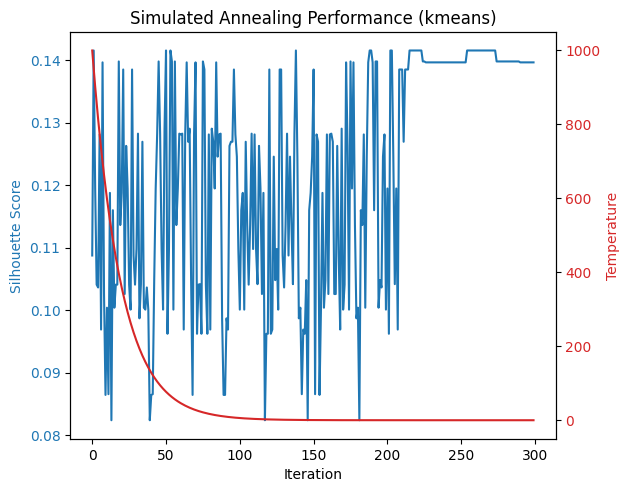

In [20]:
# Plot the performance of simulated annealing
fig, ax1 = plt.subplots()

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Silhouette Score', color='tab:blue')
ax1.plot(results[best_method]['scores'], color='tab:blue', label='Silhouette Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Temperature', color='tab:red')
ax2.plot(results[best_method]['temperatures'], color='tab:red', label='Temperature')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title(f'Simulated Annealing Performance ({best_method})')
plt.show()